In [6]:
import sys
sys.path.insert(0,'/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts')
import importlib
import torch
torch.cuda.empty_cache()

import numpy as np
import os
from datetime import datetime
import time

from torch.utils.data import DataLoader

import torch.optim as optim
from torch import nn
from torch.nn.functional import one_hot

import config
import plotUtils
import sequenceCnnModel
import sequenceDataset


importlib.reload(plotUtils)
importlib.reload(config)
importlib.reload(sequenceCnnModel)
importlib.reload(sequenceDataset)

torch.cuda.empty_cache() 

Arguments in plotUtils are {'trainingAndValidationOutputsDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/test_cnn', 'coordStoreDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/OnlyTwoCoordinateFilesForTestingSmall', 'trainingEnformerStoreFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/final_report_enformer_files/training_final_model_500k_0.0001.hdf5', 'validationEnformerStoreFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/final_report_enformer_files/validation_final_model_125k_0.0001.hdf5', 'trainingDataFile': 'trainingData.pkl', 'validationDataFile': 'validationData.pkl', 'trainingLossLearningRateFile': 'trainingLossLearningRateData.pkl', 'validationLossLearningRateFile': 'validationLossLearningRateData.pkl', 'checkpointsFile': 'modelCheckPoints', 'threshold': 0.5, 'batchSize': 128, 'learningRate': 1e-06, 'numEpochs': 20, 'u

In [7]:
arguments = {}

#Model Hyperparameters 
arguments["batchSize"] = config.modelHyperParameters.get("batchSize")
arguments["learningRate"] = config.modelHyperParameters.get("learningRate")
arguments["numberOfWorkers"] = config.modelHyperParameters.get("numberOfWorkers")
arguments["numberEpochs"] = config.modelHyperParameters.get("numberEpochs")
arguments["useCosineLearningFunction"] = config.modelHyperParameters.get("useCosineLearningFunction")
arguments["dropoutProbability"] = config.modelHyperParameters.get("dropoutProbability")
arguments["weightDecay"] = config.modelHyperParameters.get("weightDecay")

#General model configs
arguments["addLengthAsFeature"] = config.modelGeneralConfigs.get("addLengthAsFeature")
arguments["restoreFromCheckpoint"] = config.modelGeneralConfigs.get("restoreFromCheckpoint")
arguments["storePlots"] = config.modelGeneralConfigs.get("storePlots")
arguments["modelName"] = config.modelGeneralConfigs.get("modelName")

#File paths
arguments["trainingAndValidationOutputsDirectory"] = config.filePaths.get("trainingAndValidationOutputsDirectory")
arguments["trainingDataFile"] = config.filePaths.get("trainingDataFile")
arguments["validationDatafile"] = config.filePaths.get("validationDataFile")
arguments["checkpointsFile"] = config.filePaths.get("checkpointsFile")
arguments["restoreCheckpointModelDirName"] = config.filePaths.get("restoreCheckpointModelDirName")

print(f"arguments are {arguments}")

arguments are {'batchSize': 128, 'learningRate': 1e-06, 'numberOfWorkers': 12, 'numberEpochs': 5, 'useCosineLearningFunction': False, 'dropoutProbability': 0, 'weightDecay': 0, 'addLengthAsFeature': True, 'restoreFromCheckpoint': False, 'storePlots': False, 'modelName': 'specific_tracks_2_hidden_layer_lr_0.000001', 'trainingAndValidationOutputsDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/test_cnn', 'trainingDataFile': 'trainingData.pkl', 'validationDatafile': 'validationData.pkl', 'checkpointsFile': 'modelCheckPoints', 'restoreCheckpointModelDirName': '06_11_13_45_05_two_hidden_layer_lr_0.00001'}


In [8]:
def trainModelGetPredictionsForEpoch(cnnModel, dataloader, criterion, 
                              isTraining=False, optimizer = False):
    
    plotsData = {} #Dict with keys labels, inputData, predictions, epoch, loss, learningRates
    learning_rates = []

    #TODO come up with a better way to initialize this rather than creating 0s arrays. This will also remove the slicing from the return statement
    modelPredictionsToRet = np.zeros(shape = (1, 2))
    modelInputDataToRet = np.zeros(shape = (1, 10626))
    modelInputLabelsToRet = []
    
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        sequence, class_labels, _, _, _, og_sequence_length = data
        if torch.cuda.is_available():
            sequence = sequence.to("cuda")
            class_labels = class_labels.to("cuda")
        
        #Reshaping to have the structure (batches, channels, sequence_length, 4)
        batches, sequence_length, one_hot_base_length = sequence.shape
        sequence = sequence.reshape(batches, 1, sequence_length, one_hot_base_length)
        class_labels = class_labels.to(torch.int64).flatten()
        og_sequence_length = og_sequence_length.reshape(len(og_sequence_length), 1).to("cuda")
        
        #The class labels have to be encoded into probabilities of type floating point
        probabilityLabels = one_hot(class_labels, num_classes=2).to(torch.float32)
        modelPrediction = cnnModel(sequence, og_sequence_length, arguments["addLengthAsFeature"])
        loss = criterion(modelPrediction, probabilityLabels)
    
        #If the model is being trained, then do backpropagation and calculate loss. 
        if(isTraining):
            #zero grad is applicable only for optimizers and not for cosine annealing function schedulers. 
            if arguments["useCosineLearningFunction"] != True:
                optimizer.zero_grad()

            # Backward pass and calculate the gradients
            loss.backward()
            optimizer.step()

        #Collect data for plotting graphs
        # print(f"Training::: {isTraining}, loss for batch {i} is {loss.item()}")
        running_loss += loss.item()
        if arguments["useCosineLearningFunction"] and isTraining:
                learning_rates.append(optimizer.get_lr())
        # modelInputDataToRet =  np.row_stack([modelInputDataToRet, sequence.detach().cpu().numpy()])
        modelInputLabelsToRet.extend(class_labels.cpu())
        modelPredictionsToRet = np.row_stack([modelPredictionsToRet, modelPrediction.detach().cpu().numpy()])

    avg_loss_per_batch = running_loss/len(dataloader)
    plotsData["labels"] = modelInputLabelsToRet
    plotsData["inputData"] = modelInputDataToRet[1:, :]
    plotsData["predictions"] = modelPredictionsToRet[1:, :]
    
    return plotsData, avg_loss_per_batch, learning_rates

In [9]:
def objectiveFn(learningRate, numWorkers, batchSize, numEpochs, plots_directory_path):
    #TODO instead of returning as arrays, write everything to a file during model predictions. 
    trainingPlotsData = {"labels": {}, "predictions": {}, "inputData": {}, "loss": {}, "learningRates": {}}
    validationPlotsData = {"labels": {}, "predictions": {}, "inputData": {}, "loss": {}, "learningRates": {}}
    
    #Training dataloader
    trainingDataset = sequenceDataset.SequenceDataset("training")
    trainingDataloader = DataLoader(trainingDataset, batch_size=batchSize, num_workers=numWorkers,shuffle=True)

    #Validation dataloader
    validationDataset = sequenceDataset.SequenceDataset("validation")
    validationDataloader = DataLoader(validationDataset, batch_size=batchSize, num_workers=numWorkers)

        
    cnnModel = sequenceCnnModel.SequenceCnnModel(arguments["dropoutProbability"]).to('cuda')
    epoch_to_start = 1
    if(arguments["restoreFromCheckpoint"]):
        checkpoint_path = os.path.join(plots_directory_path, arguments["checkpointsFile"])
        checkpoint_dict = torch.load(checkpoint_path)
        cnnModel.load_state_dict(checkpoint_dict["model_state_dict"])
        epoch_to_start = checkpoint_dict["epoch"] + 1
        print(f"Restore from checkpoint is True.. loading previous model checkpoint and starting from epoch : {epoch_to_start}")


    #Get loss function
    training_class_weights = trainingDataset.getClassWeights()
    criterion = nn.CrossEntropyLoss(weight = torch.tensor(training_class_weights).to('cuda'))

    #Get optimizer
    optimizer = optim.Adam(cnnModel.parameters(), lr=learningRate, weight_decay=arguments["weightDecay"])

    if(arguments["restoreFromCheckpoint"]):
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
    
    training_num_batches = len(trainingDataloader)
    if arguments["useCosineLearningFunction"]:
        optimizer_steps = (training_num_batches * numEpochs) #Number of steps in gradient descent. 
        optimizer_to_use_for_training = optim.lr_scheduler.CosineAnnealingLR(optimizer, optimizer_steps, last_epoch = -1, eta_min=0)
    else:
        optimizer_to_use_for_training = optimizer

    #Train model and validate it for each epoch
    for epoch in range(epoch_to_start, numEpochs + 1):
        print(f"Starting training for epoch {epoch}")
        trainingPlotsData, training_loss, training_learning_rates = trainModelGetPredictionsForEpoch(cnnModel, 
                                            trainingDataloader, criterion, isTraining=True, optimizer=optimizer_to_use_for_training)
        trainingPlotsData["epoch"] = epoch
        print(f"Finished training for epoch {epoch}. Starting validations")
        
        #Validation
        with torch.no_grad():
            validationPlotsData, validation_loss, validation_learning_rates =  trainModelGetPredictionsForEpoch(
                                                cnnModel, validationDataloader, criterion, isTraining=False)
            validationPlotsData["epoch"] = epoch
            
        #For every epoch, save the model checkpoint and the plotsData so far. 
        plotUtils.saveModelCheckpoint(epoch, cnnModel, optimizer, plots_directory_path)
        plotUtils.savePlotsData("training", trainingPlotsData, training_loss, training_learning_rates, plots_directory_path)
        plotUtils.savePlotsData("validation", validationPlotsData, validation_loss, validation_learning_rates, plots_directory_path)
        
    print(f"Completed training and validation. Saving model and plotting loss function graphs. ")
    plotUtils.storePlots(plots_directory_path, modelInputType="Sequence")

Start time is 1699622203.1776624
The model hyper parameters are Learning rate: 1e-06, Number of epochs: 5, batch size: 128
Total number of samples in all files combined is 726
Total number of samples in all files combined is 164
Starting training for epoch 1
Finished training for epoch 1. Starting validations
Inside save model check point
Starting training for epoch 2
Finished training for epoch 2. Starting validations
Inside save model check point
Starting training for epoch 3
Finished training for epoch 3. Starting validations
Inside save model check point
Starting training for epoch 4
Finished training for epoch 4. Starting validations
Inside save model check point
Starting training for epoch 5
Finished training for epoch 5. Starting validations
Inside save model check point
Completed training and validation. Saving model and plotting loss function graphs. 


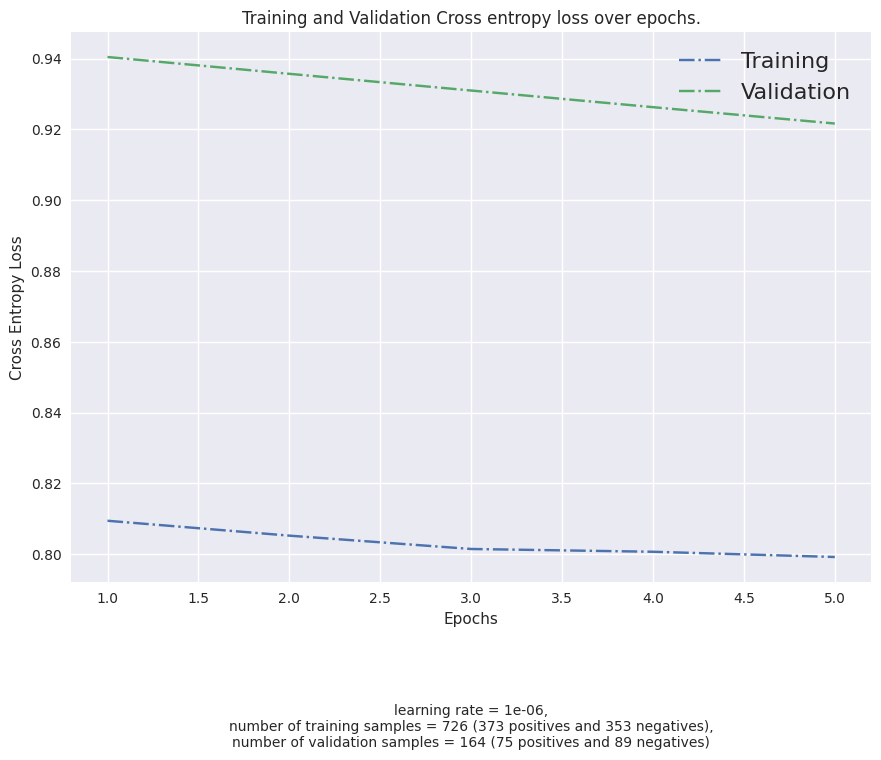

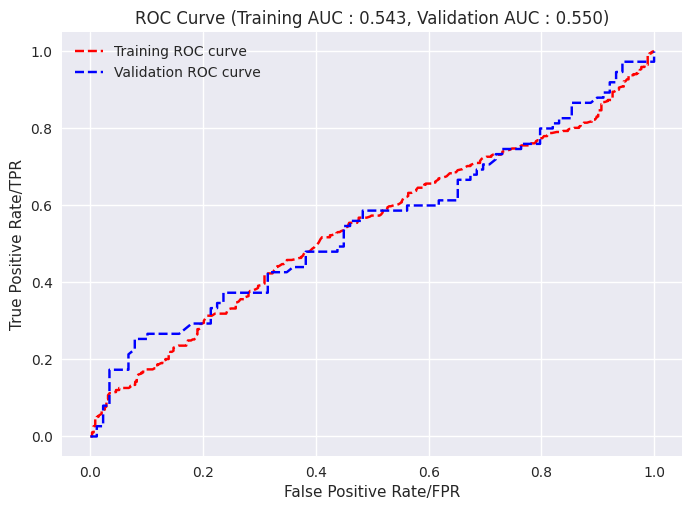

<Figure size 800x550 with 0 Axes>

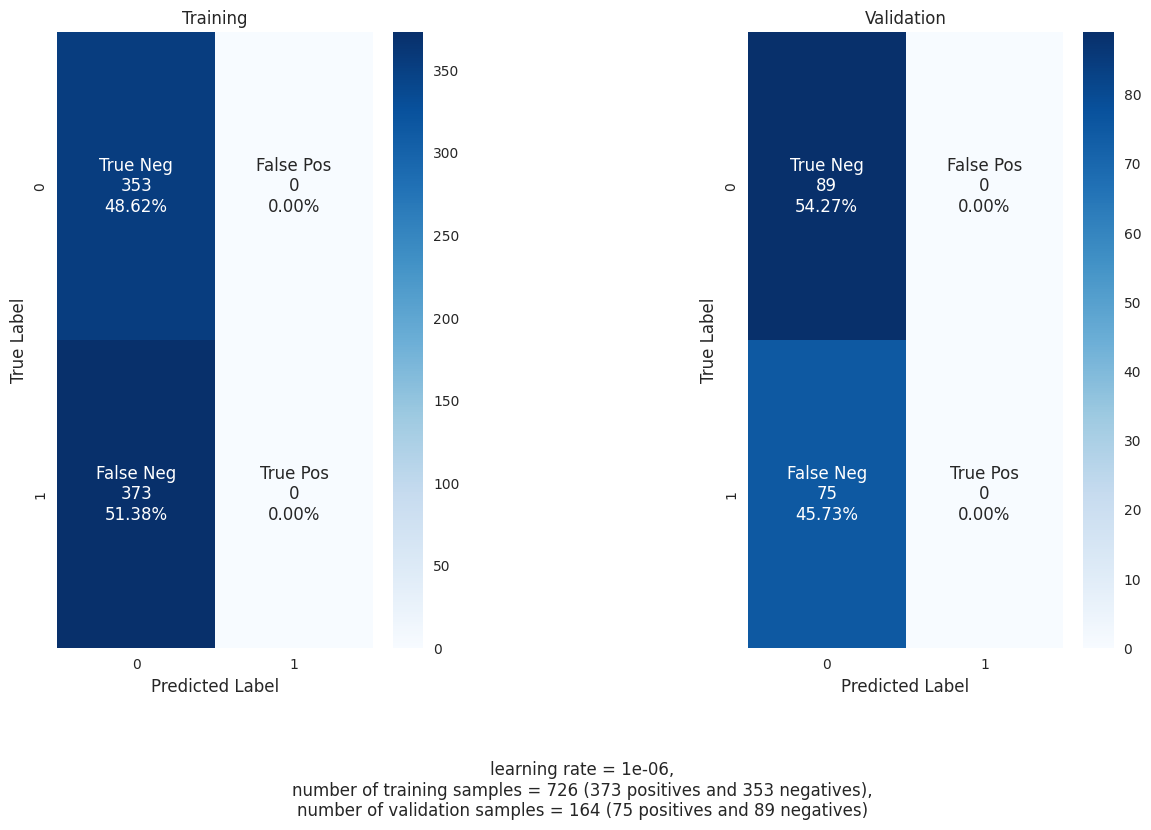

<Figure size 800x550 with 0 Axes>

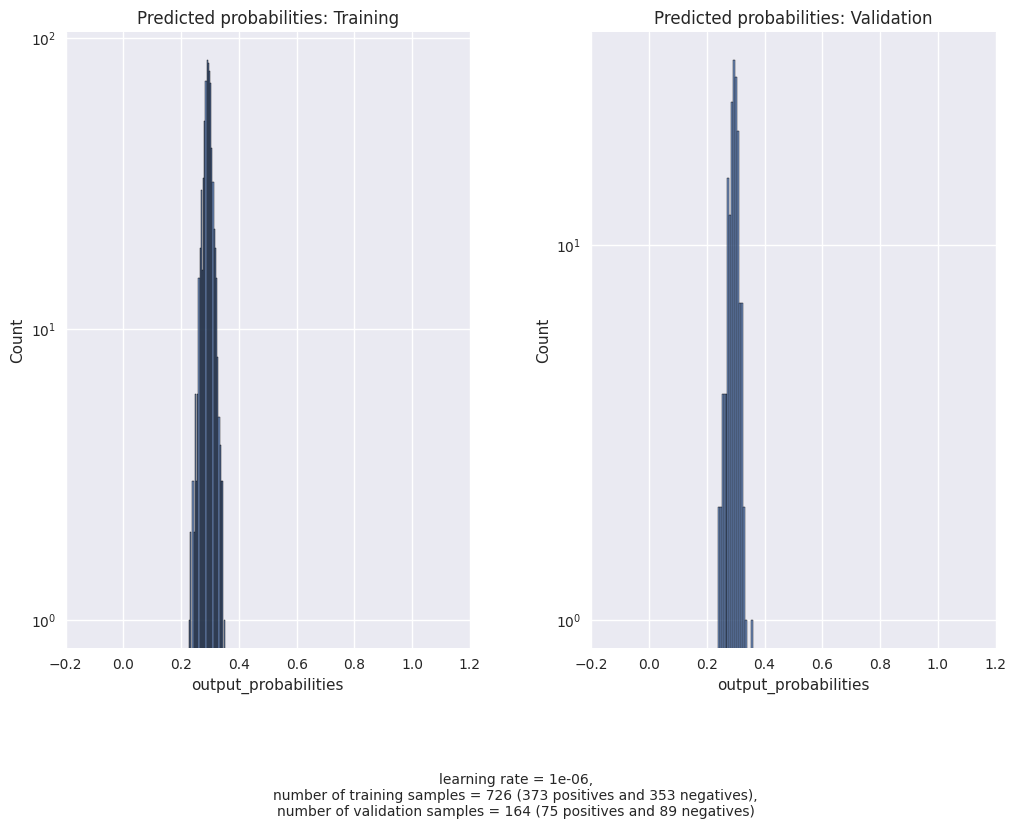

<Figure size 800x550 with 0 Axes>

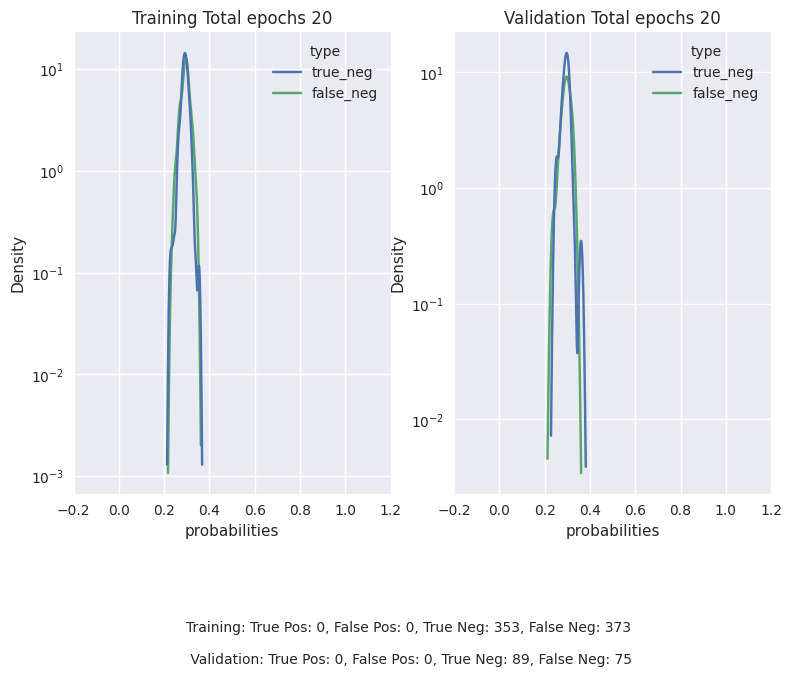

End time is 1699622227.5348797


In [13]:
if __name__ == '__main__':
    print(f"Start time is {time.time()}")

    learningRate = arguments["learningRate"]
    numWorkers = arguments["numberOfWorkers"]
    numEpochs = arguments["numberEpochs"]
    batchSize = arguments["batchSize"]

    print(f"The model hyper parameters are Learning rate: {learningRate}, Number of epochs: {numEpochs}, batch size: {batchSize}")
    
    #TODO if the model is restarted, use existing plots directory
    
    #Create the directories for plots and checkpoints
    if(arguments["restoreFromCheckpoint"]):
        plots_directory_name = arguments["restoreCheckpointModelDirName"]
        plots_directory_path = os.path.join(arguments["trainingAndValidationOutputsDirectory"], plots_directory_name)
    else:
        now = datetime.now()
        filename_extension = now.strftime("%d_%m_%H_%M_%S")
        plots_directory_name = filename_extension + "_" + str(arguments["modelName"])
        plots_directory_path = os.path.join(arguments["trainingAndValidationOutputsDirectory"], plots_directory_name)
        
        os.mkdir(plots_directory_path)

    objectiveFn(learningRate, numWorkers, batchSize, numEpochs, plots_directory_path)
    print(f"End time is {time.time()}")